This notebook compares the performance among different Jaccard similarity approaches.
We run the registration process over 4 generated sources (one of each type) with scale factor 1000.
The process parses and loads the sources into the system, then for each pair of sources we collect candidate similar pairs and compare them using the Jaccard distance. The following lists the approaches being compared:

 - **Exhaustive**: any pair of nodes is a candidate pair (excluding nodes with labels that are empty, exact matches, or refer to numeric or boolean types).
 - **CommonWord**: the labels of the pair nodes need to share at least one word (and we exclude the pairs that Exhaustive excludes).
 - **RelativeLength=.2**: the labels of the pair nodes must have lengths within 20% of one another (and we exclude the pairs that Exhaustive excludes).
 - **MinHash-LSH**: uses the MinHash-LSH hashing, to assign LSH signatures to the label of each node/edge. The signatures are split into **b** bands of **r** rows each. The probability two signatures match on at least one band is proportional to the Jaccard similarity.


In [519]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [520]:
def prepare(filename, name, pairproc='JaccardLSHPairProcessor'):
    result = pd.read_csv(filename, sep='\t', header=0, comment='#')
    result['NAME'] = name
    result = result[result['INPUT']==pairproc]
    result = result[['NAME', 'HITS', 'TOTAL', 'TIME']] #.groupby('NAME').sum()
    return result

In [521]:
def scores(df):
    gt = df[df['NAME']=='Exhaustive'].to_dict('records')[0]
    df['FP'] = df['TOTAL']-df['HITS']
    df['FN'] = gt['HITS']-df['HITS']
    df['PRECISION'] = df['HITS']/df['TOTAL']
    df['RECALL'] = df['HITS']/(df['HITS']+df['FN'])
    df['F1'] = 2/((1/df['RECALL'])+(1/df['PRECISION']))
    return df

## Precision, recall, F1
The following chart shows the customary precision, recall, and F1-measure.
A **true positive** is here a node pair **retrieved** and having Jaccard similarity **above the .5** threshold.
A **false positive** is node pair that was **retrieved** as a candidate, but whose Jaccard similarity was in fact **below the threshold**.
A **false negative** is node pair that was **not retrieved** as a candidate, although its Jaccard similarity was above the threshold.
Thus, the precision, recall and F1 are all given wrt to the **.5** mark.**Ioana: need to define the entities being measured here. What is the precision of a method M? The number of pairs whose Jaccard similarity is higher than what? divided by the number of pairs it compares? If 0.5 was the threshold used, is this meaningful?** In our case, good recall is the more important than precision, as it is more important to minimize false negatives than false positives.
That said, although CommonWord is nearly perfect (the discrepancy comes from the difference in tokenization used in the Jaccard function and the common word), the precision is quite low, which motivate looking for better solutions.

## Execution times
Note that in the current implementation, all the pairs are generated using a SQL queries regardless of the approach. These execution times are given for completeness but should be taken with a grain of salt as no particular attention has been devoted to performance yet.
For the records, a quick evaluation of **CommonWord** with the iterative and cached approached used in the demo, show the execution time can be **reduced with a factor x10**.**Ioana: which of the methods benefited from appropriate indexes? e.g. did CommonWord benefit from a full-text index? If index support was uneven or missing, we cannot really interpret these running times.** This explains why in terms of execution time are all quite similar and the exhaustive method is actually not the worst.**Julien:** I think the results still say something interesting about the worst case be should expect from each method. Also, it shows how LSH is sensitive to the parameters in use.I have yet to find an efficient way to make use of Postgres's indexes for LSH.

# Dataset: generated w/ sf=100
The following Minhash-LSH experiments were run with a number of LSH buckets and **vocabulary size of 1M**. 
The Jaccard similarity threshold is set to **0.5**, so the exhaustive approach shows that there are **70K** pairs to compare with just **50** pairs with Jaccard similarity above 1/2.

In [40]:
df_exh = prepare('../lsh/generated-100-exhaustive.log', 'Exhaustive', pairproc='JaccardPairProcessor')
df_common = prepare('../lsh/generated-100-commonword.log', 'Common Word', pairproc='JaccardPairProcessor')
df_length = prepare('../lsh/generated-100-relativelength-.2.log', 'RelativeLength=.2', pairproc='JaccardPairProcessor')
df = df_exh.append(df_common).append(df_length)
for b in {"2", "4", "8", "16", "32"}:
    for r in {"1", "2", "4", "8"}:
        df = df.append(prepare('../lsh/generated-100-minhashlsh-b='+b+'-r='+r+'.log', 'MinhashLSH b='+b+', r='+r+''))
df

NAME  HITS     TOTAL    TIME
1            Exhaustive  50.0   70441.0   769.0
1           Common Word  45.0    2235.0  1088.0
1     RelativeLength=.2  32.0  274346.0  5991.0
1   MinhashLSH b=2, r=2   2.0      31.0   225.0
1   MinhashLSH b=2, r=4   NaN       NaN   214.0
1   MinhashLSH b=2, r=8   NaN       NaN   216.0
1   MinhashLSH b=2, r=1  12.0     147.0   249.0
1  MinhashLSH b=16, r=2  10.0     136.0   490.0
1  MinhashLSH b=16, r=4   6.0      18.0   467.0
1  MinhashLSH b=16, r=8   NaN       1.0   460.0
1  MinhashLSH b=16, r=1  12.0     200.0   499.0
1   MinhashLSH b=8, r=2   8.0      92.0   337.0
1   MinhashLSH b=8, r=4   2.0       6.0   532.0
1   MinhashLSH b=8, r=8   NaN       1.0   319.0
1   MinhashLSH b=8, r=1  12.0     193.0   355.0
1  MinhashLSH b=32, r=2  12.0     172.0   629.0
1  MinhashLSH b=32, r=4   6.0      43.0   787.0
1  MinhashLSH b=32, r=8   NaN       7.0   599.0
1  MinhashLSH b=32, r=1  12.0     203.0   631.0
1   MinhashLSH b=4, r=2   4.0      56.0   253.0
1   MinhashLSH b=4, r=4   NaN       NaN   234.0
1   MinhashLSH b=4, r=8   NaN       NaN   245.0
1   MinhashLSH b=4, r=1  12.0     177.0   276.0

## Precision, recall, F1

In [41]:
sc = scores(df)[1:]
sc

NAME  HITS     TOTAL    TIME        FP    FN  PRECISION  \
1           Common Word  45.0    2235.0  1088.0    2190.0   5.0   0.020134   
1     RelativeLength=.2  32.0  274346.0  5991.0  274314.0  18.0   0.000117   
1   MinhashLSH b=2, r=2   2.0      31.0   225.0      29.0  48.0   0.064516   
1   MinhashLSH b=2, r=4   NaN       NaN   214.0       NaN   NaN        NaN   
1   MinhashLSH b=2, r=8   NaN       NaN   216.0       NaN   NaN        NaN   
1   MinhashLSH b=2, r=1  12.0     147.0   249.0     135.0  38.0   0.081633   
1  MinhashLSH b=16, r=2  10.0     136.0   490.0     126.0  40.0   0.073529   
1  MinhashLSH b=16, r=4   6.0      18.0   467.0      12.0  44.0   0.333333   
1  MinhashLSH b=16, r=8   NaN       1.0   460.0       NaN   NaN        NaN   
1  MinhashLSH b=16, r=1  12.0     200.0   499.0     188.0  38.0   0.060000   
1   MinhashLSH b=8, r=2   8.0      92.0   337.0      84.0  42.0   0.086957   
1   MinhashLSH b=8, r=4   2.0       6.0   532.0       4.0  48.0   0.333333   
1   MinhashLSH b=8, r=8   NaN       1.0   319.0       NaN   NaN        NaN   
1   MinhashLSH b=8, r=1  12.0     193.0   355.0     181.0  38.0   0.062176   
1  MinhashLSH b=32, r=2  12.0     172.0   629.0     160.0  38.0   0.069767   
1  MinhashLSH b=32, r=4   6.0      43.0   787.0      37.0  44.0   0.139535   
1  MinhashLSH b=32, r=8   NaN       7.0   599.0       NaN   NaN        NaN   
1  MinhashLSH b=32, r=1  12.0     203.0   631.0     191.0  38.0   0.059113   
1   MinhashLSH b=4, r=2   4.0      56.0   253.0      52.0  46.0   0.071429   
1   MinhashLSH b=4, r=4   NaN       NaN   234.0       NaN   NaN        NaN   
1   MinhashLSH b=4, r=8   NaN       NaN   245.0       NaN   NaN        NaN   
1   MinhashLSH b=4, r=1  12.0     177.0   276.0     165.0  38.0   0.067797   

   RECALL        F1  
1    0.90  0.039387  
1    0.64  0.000233  
1    0.04  0.049383  
1     NaN       NaN  
1     NaN       NaN  
1    0.24  0.121827  
1    0.20  0.107527  
1    0.12  0.176471  
1     NaN       NaN  
1    0.24  0.096000  
1    0.16  0.112676  
1    0.04  0.071429  
1     NaN       NaN  
1    0.24  0.098765  
1    0.24  0.108108  
1    0.12  0.129032  
1     NaN       NaN  
1    0.24  0.094862  
1    0.08  0.075472  
1     NaN       NaN  
1     NaN       NaN  
1    0.24  0.105727

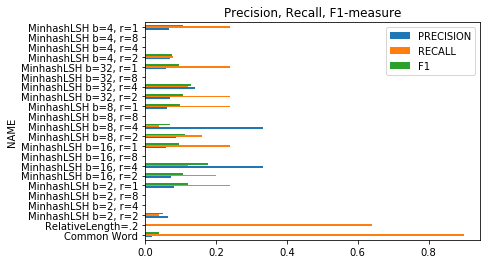

In [42]:
sc[['NAME', 'PRECISION', 'RECALL', 'F1']].plot(kind='barh',title='Precision, Recall, F1-measure', x='NAME')

## Execution times

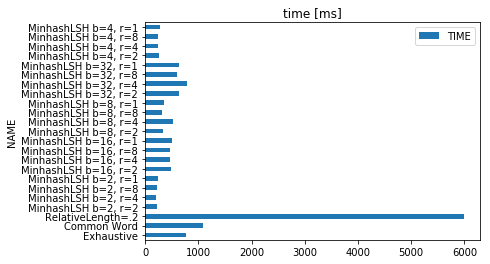

In [43]:
df[['NAME', 'TIME']].plot(kind='barh',title='time [ms]', x='NAME')

## Conclusion @ sf=100
TODO

# Dataset: generated w/ sf=1000
The following Minhash-LSH experiments were run with a number of LSH buckets and **vocabulary size of 1M**. 
The Jaccard similarity threshold is set to **0.5**, so the exhaustive approach shows that there are **3M** pairs to compare with just over **900** pairs with Jaccard similarity above 1/2.

In [44]:
df_exh = prepare('../lsh/generated-1000-exhaustive.log', 'Exhaustive', pairproc='JaccardPairProcessor')
df_common = prepare('../lsh/generated-1000-commonword.log', 'Common Word', pairproc='JaccardPairProcessor')
df_length = prepare('../lsh/generated-1000-relativelength-.2.log', 'RelativeLength=.2', pairproc='JaccardPairProcessor')
df = df_exh.append(df_common).append(df_length)
for b in {"2", "4", "8", "16", "32"}:
    for r in {"1", "2", "4", "8"}:
        df = df.append(prepare('../lsh/generated-1000-minhashlsh-b='+b+'-r='+r+'.log', 'MinhashLSH b='+b+', r='+r+''))
df

NAME   HITS      TOTAL     TIME
1            Exhaustive  904.0  3155478.0  23271.0
1           Common Word  864.0    47796.0  43599.0
1     RelativeLength=.2  198.0  1029651.0  23868.0
1   MinhashLSH b=2, r=2  229.0     2098.0   9712.0
1   MinhashLSH b=2, r=4   53.0      245.0   9562.0
1   MinhashLSH b=2, r=8    1.0        7.0   9494.0
1   MinhashLSH b=2, r=1  496.0     5821.0   9770.0
1  MinhashLSH b=16, r=2  692.0     9000.0  20418.0
1  MinhashLSH b=16, r=4  375.0     2067.0  20229.0
1  MinhashLSH b=16, r=8   47.0      111.0  20064.0
1  MinhashLSH b=16, r=1  700.0    10941.0  20423.0
1   MinhashLSH b=8, r=2  654.0     6781.0  13958.0
1   MinhashLSH b=8, r=4  245.0     1168.0  20925.0
1   MinhashLSH b=8, r=8   27.0       44.0  13661.0
1   MinhashLSH b=8, r=1  694.0     9949.0  14026.0
1  MinhashLSH b=32, r=2  700.0    10773.0  26072.0
1  MinhashLSH b=32, r=4  495.0     3321.0  25889.0
1  MinhashLSH b=32, r=8   78.0      226.0  25745.0
1  MinhashLSH b=32, r=1  700.0    10969.0  28670.0
1   MinhashLSH b=4, r=2  435.0     3622.0  17475.0
1   MinhashLSH b=4, r=4  122.0      515.0  10212.0
1   MinhashLSH b=4, r=8    8.0       24.0  10204.0
1   MinhashLSH b=4, r=1  631.0     8128.0  10537.0

## Precision, recall, F1
The following chart shows the customary precision, recall, and F1-measure.
A **true positive** is here a node pair **retrieved** and having Jaccard similarity **above the .5** threshold.
A **false positive** is node pair that was **retrieved** as a candidate, but whose Jaccard similarity was in fact **below the threshold**.
A **false negative** is node pair that was **not retrieved** as a candidate, although its Jaccard similarity was above the threshold.
Thus, the precision, recall and F1 are all given wrt to the **.5** mark.**Ioana: need to define the entities being measured here. What is the precision of a method M? The number of pairs whose Jaccard similarity is higher than what? divided by the number of pairs it compares? If 0.5 was the threshold used, is this meaningful?** In our case, good recall is the more important than precision, as it is more important to minimize false negatives than false positives.
That said, although CommonWord is nearly perfect (the discrepancy comes from the difference in tokenization used in the Jaccard function and the common word), the precision is quite low, which motivate looking for better solutions.

In [45]:
sc = scores(df)[1:]
sc

NAME   HITS      TOTAL     TIME         FP     FN  \
1           Common Word  864.0    47796.0  43599.0    46932.0   40.0   
1     RelativeLength=.2  198.0  1029651.0  23868.0  1029453.0  706.0   
1   MinhashLSH b=2, r=2  229.0     2098.0   9712.0     1869.0  675.0   
1   MinhashLSH b=2, r=4   53.0      245.0   9562.0      192.0  851.0   
1   MinhashLSH b=2, r=8    1.0        7.0   9494.0        6.0  903.0   
1   MinhashLSH b=2, r=1  496.0     5821.0   9770.0     5325.0  408.0   
1  MinhashLSH b=16, r=2  692.0     9000.0  20418.0     8308.0  212.0   
1  MinhashLSH b=16, r=4  375.0     2067.0  20229.0     1692.0  529.0   
1  MinhashLSH b=16, r=8   47.0      111.0  20064.0       64.0  857.0   
1  MinhashLSH b=16, r=1  700.0    10941.0  20423.0    10241.0  204.0   
1   MinhashLSH b=8, r=2  654.0     6781.0  13958.0     6127.0  250.0   
1   MinhashLSH b=8, r=4  245.0     1168.0  20925.0      923.0  659.0   
1   MinhashLSH b=8, r=8   27.0       44.0  13661.0       17.0  877.0   
1   MinhashLSH b=8, r=1  694.0     9949.0  14026.0     9255.0  210.0   
1  MinhashLSH b=32, r=2  700.0    10773.0  26072.0    10073.0  204.0   
1  MinhashLSH b=32, r=4  495.0     3321.0  25889.0     2826.0  409.0   
1  MinhashLSH b=32, r=8   78.0      226.0  25745.0      148.0  826.0   
1  MinhashLSH b=32, r=1  700.0    10969.0  28670.0    10269.0  204.0   
1   MinhashLSH b=4, r=2  435.0     3622.0  17475.0     3187.0  469.0   
1   MinhashLSH b=4, r=4  122.0      515.0  10212.0      393.0  782.0   
1   MinhashLSH b=4, r=8    8.0       24.0  10204.0       16.0  896.0   
1   MinhashLSH b=4, r=1  631.0     8128.0  10537.0     7497.0  273.0   

   PRECISION    RECALL        F1  
1   0.018077  0.955752  0.035483  
1   0.000192  0.219027  0.000384  
1   0.109152  0.253319  0.152565  
1   0.216327  0.058628  0.092254  
1   0.142857  0.001106  0.002195  
1   0.085209  0.548673  0.147509  
1   0.076889  0.765487  0.139742  
1   0.181422  0.414823  0.252440  
1   0.423423  0.051991  0.092611  
1   0.063980  0.774336  0.118193  
1   0.096446  0.723451  0.170202  
1   0.209760  0.271018  0.236486  
1   0.613636  0.029867  0.056962  
1   0.069756  0.767699  0.127891  
1   0.064977  0.774336  0.119894  
1   0.149051  0.547566  0.234320  
1   0.345133  0.086283  0.138053  
1   0.063816  0.774336  0.117915  
1   0.120099  0.481195  0.192223  
1   0.236893  0.134956  0.171952  
1   0.333333  0.008850  0.017241  
1   0.077633  0.698009  0.139725

Among the Minhash-LSH approach, the best best are obtained with small r values (1 or 2). Interestingly, for each number of bands, the best F1-measure is obtained when the r is close to the theorical limit for the given threshold, i.e. log(1/b)/log(threshold).

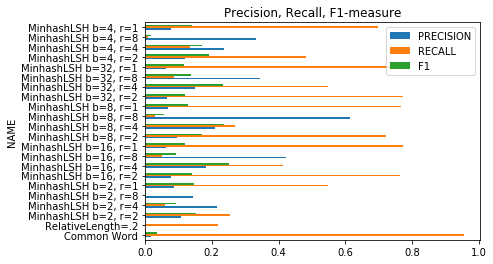

In [46]:
sc[['NAME', 'PRECISION', 'RECALL', 'F1']].plot(kind='barh',title='Precision, Recall, F1-measure', x='NAME')

## Execution times

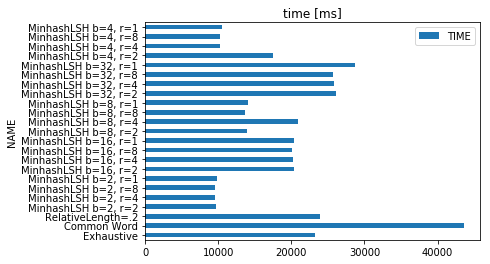

In [47]:
df[['NAME', 'TIME']].plot(kind='barh',title='time [ms]', x='NAME')

## Conclusion @ sf=1000
Although the main advantage of CommonWord is near perfect recall, it is the slowest approach and has poor recall. The length based approach is bad in every respect and should be discarded for good.
Among the minhash LSH methods, it is not clear with should favor F1 over recall. For instance, (b=32, r=4) has comparatively high F1 measure, it only collect over half of the target pairs.

A good compromise seems to be achieved with b in {8 , 16} and r in {1, 2}, with decent execution times, and a relatively small portion of the target pair lost.

# Dataset: generated w/ sf=10000
The following Minhash-LSH experiments were run with a number of LSH buckets and **vocabulary size of 1M**. 
The Jaccard similarity threshold is set to **0.5**, so the exhaustive approach shows that there are **46M** pairs to compare with just over **69K** pairs with Jaccard similarity above 1/2.

## Conclusion @ sf=10000
At the time of this writing, the experiments was still running after over 48h.
